# Deep Learning-Based Classification of Chest X-Ray Images for Respiratory Disease Detection
A Convolutional Neural Network Approach for Automated Medical Imaging Analysis Enabling Multi-Class Classification of COVID-19, Pneumonia, and Tuberculosis Cases Compared Against Normal Chest Radiographs for Enhanced Diagnostic Accuracy Supporting Healthcare Professionals in Early Disease Detection and Patient Care

## Import Dependences

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from itertools import cycle
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical

2025-05-28 19:40:33.635341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748461233.842328      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748461233.898363      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Check Versions

In [3]:
tf.__version__,cv2.__version__

('2.18.0', '4.11.0')

In [4]:
!python --version

Python 3.11.11


## Check Devices

In [5]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load Dataset

In [6]:
# Define paths
base_dir = "/kaggle/input/cxr-data-set"
output_dir = "/kaggle/working/split_data"  # Kaggle working directory
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")

# Classes (folder names)
classes = ["Covid", "Normal", "Pneumonia", "Tuberculosis"]

# Split ratios
test_size = 0.1   # 10% test
val_size = 0.1    # 10% validation
# train_size = 0.8  # 80% train (remaining)

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes:
    # Make class subdirectories in train, validation & test
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Get all images for this class
    src_dir = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(src_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # First split: separate test set (10%)
    train_val_imgs, test_imgs = train_test_split(
        images, 
        test_size=test_size, 
        random_state=42
    )
    
    # Second split: separate validation from remaining data
    # val_size / (1 - test_size) gives us 10% of original data for validation
    val_ratio = val_size / (1 - test_size)
    train_imgs, val_imgs = train_test_split(
        train_val_imgs, 
        test_size=val_ratio, 
        random_state=42
    )
    
    # Copy images to respective folders
    for img in train_imgs:
        shutil.copy(os.path.join(src_dir, img), os.path.join(train_dir, cls, img))
    
    for img in val_imgs:
        shutil.copy(os.path.join(src_dir, img), os.path.join(val_dir, cls, img))
    
    for img in test_imgs:
        shutil.copy(os.path.join(src_dir, img), os.path.join(test_dir, cls, img))
    
    print(f"{cls}: Total={len(images)}, Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

print("\nData splitting completed!")
print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

Covid: Total=18011, Train=14407, Val=1802, Test=1802
Normal: Total=18096, Train=14476, Val=1810, Test=1810
Pneumonia: Total=18187, Train=14549, Val=1819, Test=1819
Tuberculosis: Total=18002, Train=14400, Val=1801, Test=1801

Data splitting completed!
Train directory: /kaggle/working/split_data/train
Validation directory: /kaggle/working/split_data/validation
Test directory: /kaggle/working/split_data/test


In [7]:
train_path = '/kaggle/working/split_data/train'
valid_path = '/kaggle/working/split_data/validation'
test_path = '/kaggle/working/split_data/test'

## Data Visualization

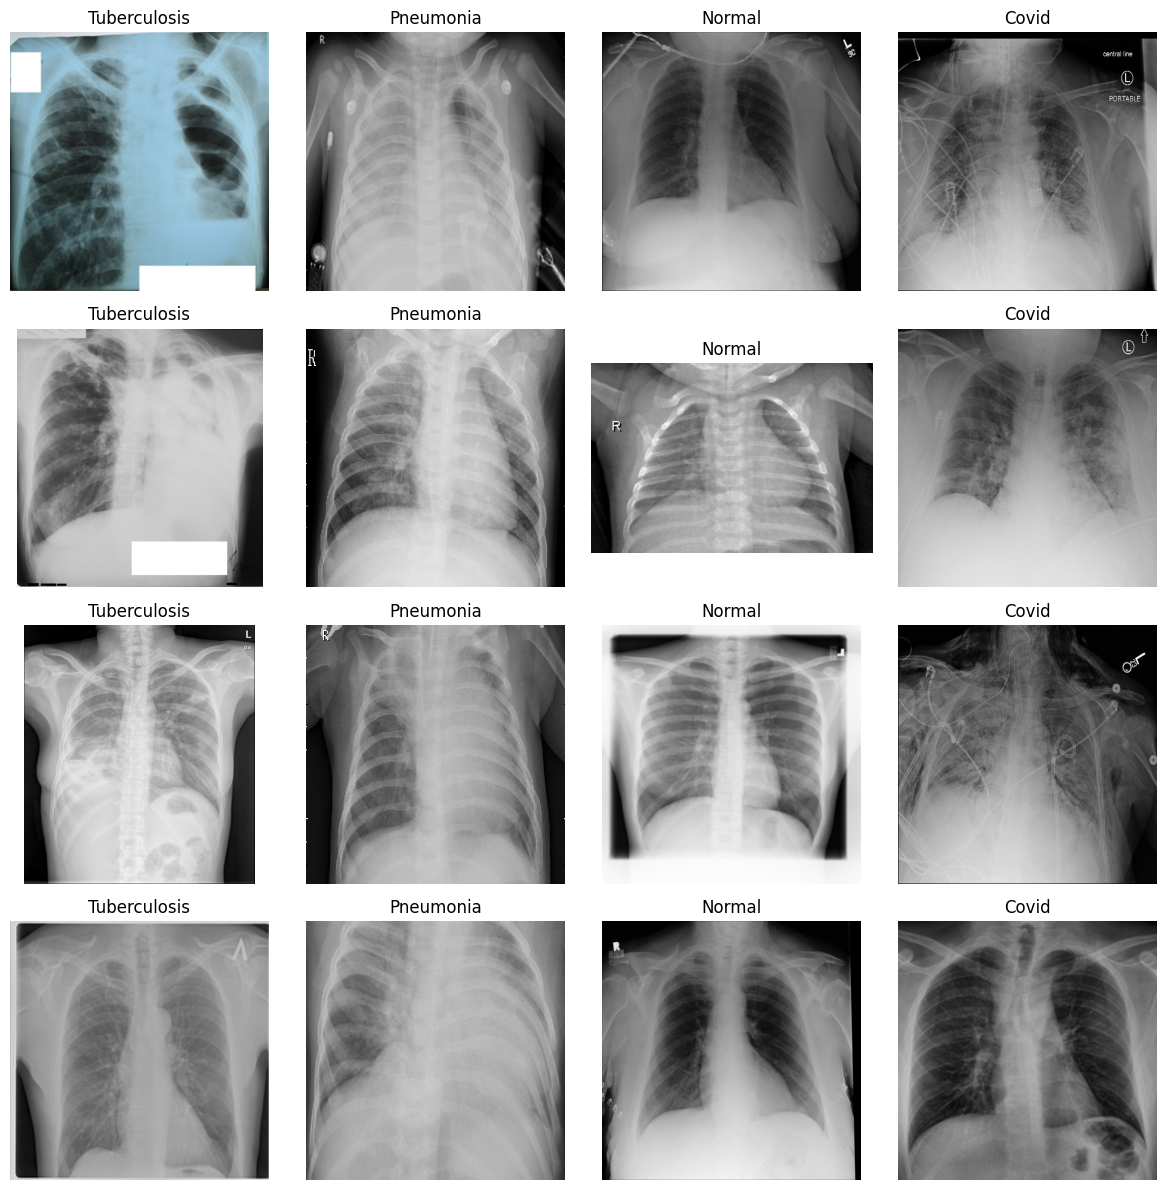

In [8]:
main_folder = r'/kaggle/working/split_data/train'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

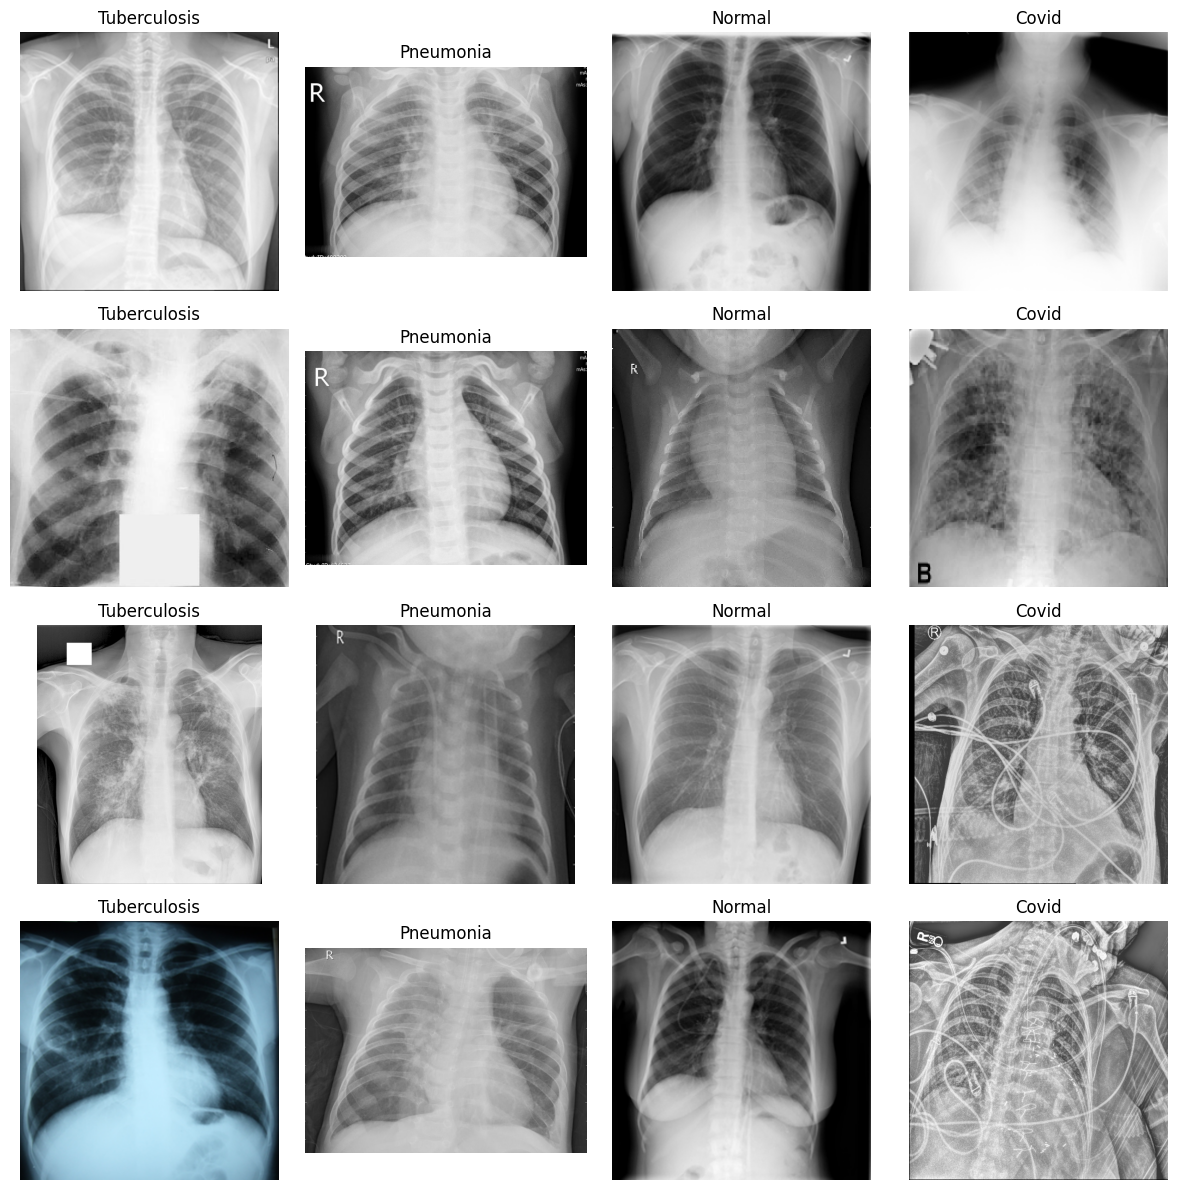

In [9]:
main_folder = r'/kaggle/working/split_data/validation'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

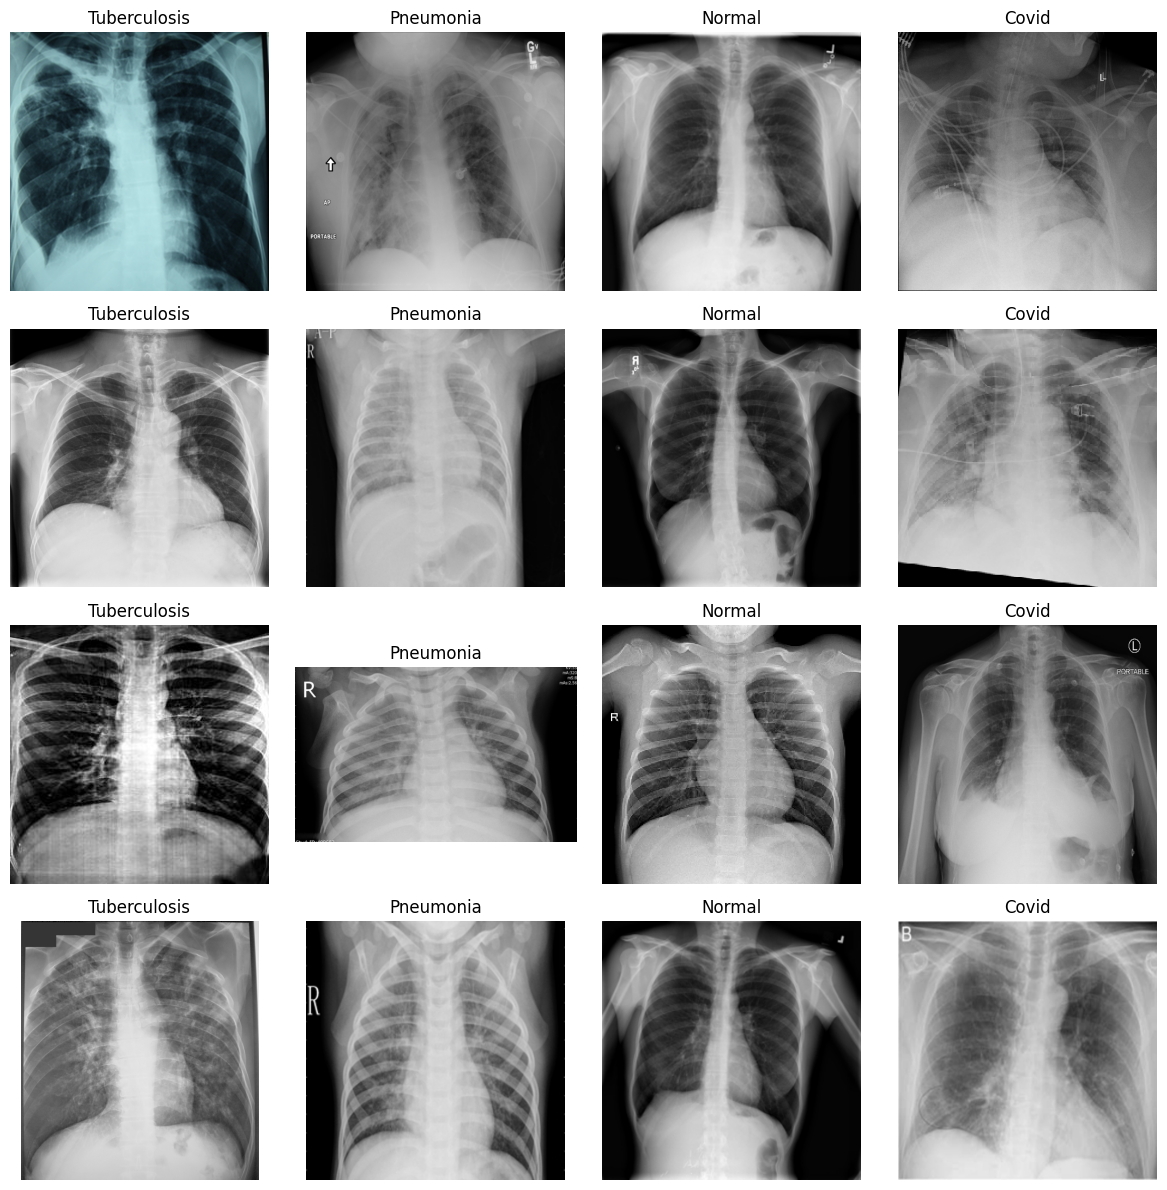

In [10]:
main_folder = r'/kaggle/working/split_data/test'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

## Data Preprocessing

In [11]:
IMAGE_SIZE = 224

BATCH_SIZE = 32

In [12]:
def cnn_preprocess(x):
    return x/255.0

In [13]:
cnn_train_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_train_generator = cnn_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 57832 images belonging to 4 classes.


In [14]:
cnn_train_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2, 'Tuberculosis': 3}

In [15]:
cnn_valid_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_valid_generator = cnn_valid_datagen.flow_from_directory(
        valid_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 7232 images belonging to 4 classes.


In [16]:
cnn_valid_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2, 'Tuberculosis': 3}

In [17]:
cnn_test_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_test_generator = cnn_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 7232 images belonging to 4 classes.


In [18]:
cnn_test_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2, 'Tuberculosis': 3}

## CNN Model Building

In [19]:
cnn_model = keras.Sequential([
    keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),

    keras.layers.Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
])

I0000 00:00:1748461724.701605      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [20]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,200,964 (42.73 MB)

 Trainable params: 11,200,964 (42.73 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [22]:
cnn_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.F1Score(name='f1_score')
])

In [23]:
cnn_history = cnn_model.fit(
        cnn_train_generator,
        epochs = 20,
        validation_data = cnn_valid_generator,
        callbacks = callbacks
        )

Epoch 1/20


I0000 00:00:1748461734.638085      88 service.cc:148] XLA service 0x7f8d04005240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748461734.638772      88 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748461735.281803      88 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1808 ━━━━━━━━━━━━━━━━━━━━ 1:54 64ms/step - accuracy: 0.2422 - f1_score: 0.1602 - loss: 1.3686 - precision: 0.0000e+00 - recall: 0.0000e+00  

I0000 00:00:1748461740.965376      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1808/1808 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7776 - f1_score: 0.7766 - loss: 0.5721 - precision: 0.8373 - recall: 0.7143
Epoch 1: val_loss improved from inf to 0.30564, saving model to CNN_best_model.keras
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 893s 488ms/step - accuracy: 0.7776 - f1_score: 0.7767 - loss: 0.5720 - precision: 0.8374 - recall: 0.7144 - val_accuracy: 0.8985 - val_f1_score: 0.8987 - val_loss: 0.3056 - val_precision: 0.9202 - val_recall: 0.8679 - learning_rate: 0.0010
Epoch 2/20
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9143 - f1_score: 0.9143 - loss: 0.2480 - precision: 0.9267 - recall: 0.9035
Epoch 2: val_loss improved from 0.30564 to 0.19610, saving model to CNN_best_model.keras
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 800s 442ms/step - accuracy: 0.9143 - f1_score: 0.9143 - loss: 0.2480 - precision: 0.9267 - recall: 0.9035 - val_accuracy: 0.9357 - val_f1_score: 0.9359 - val_loss: 0.1961 - val_precision: 0.9429 - val_recall: 0.9296 - learning_rate: 0.0010
Epo

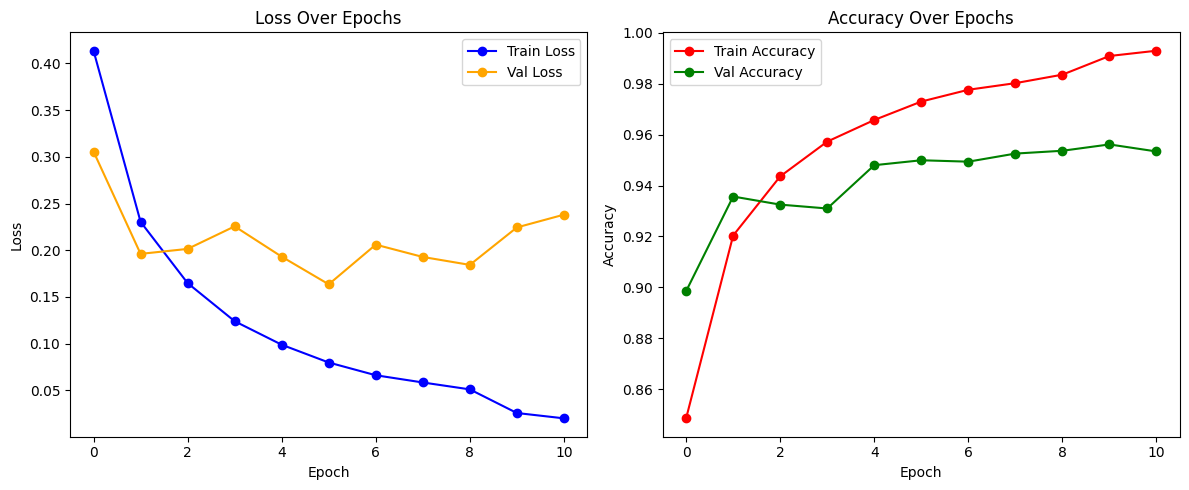

In [24]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model performance testing

In [25]:
cnn_predictions = cnn_model.predict(cnn_test_generator)

226/226 ━━━━━━━━━━━━━━━━━━━━ 102s 451ms/step


In [26]:
cnn_result = cnn_model.evaluate(cnn_test_generator, batch_size=BATCH_SIZE)

226/226 ━━━━━━━━━━━━━━━━━━━━ 81s 357ms/step - accuracy: 0.9514 - f1_score: 0.9511 - loss: 0.1632 - precision: 0.9536 - recall: 0.9481


In [27]:
history = {
    "CNN": {"accuracy": cnn_history.history['accuracy'],
            "val_accuracy": cnn_history.history['val_accuracy'] ,
            "loss": cnn_history.history['loss'],"val_loss": cnn_history.history['val_loss']}}

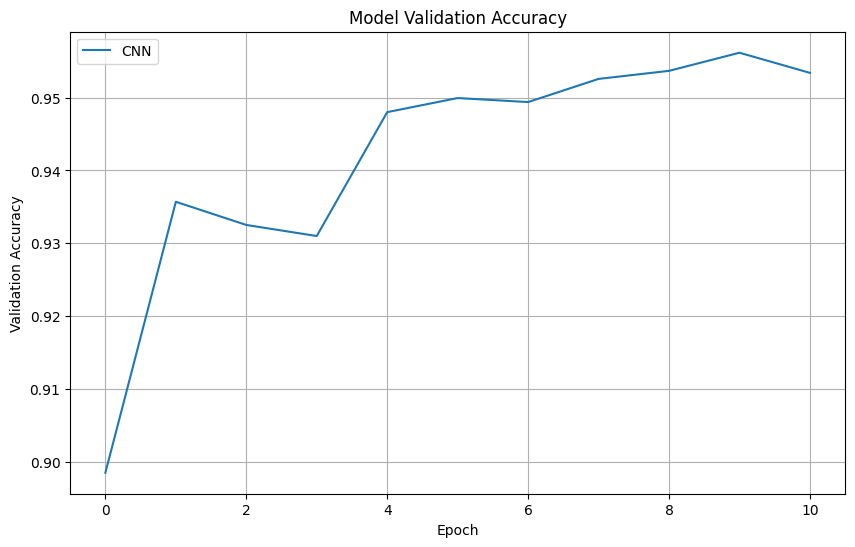

In [28]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_accuracy'], label=model)
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

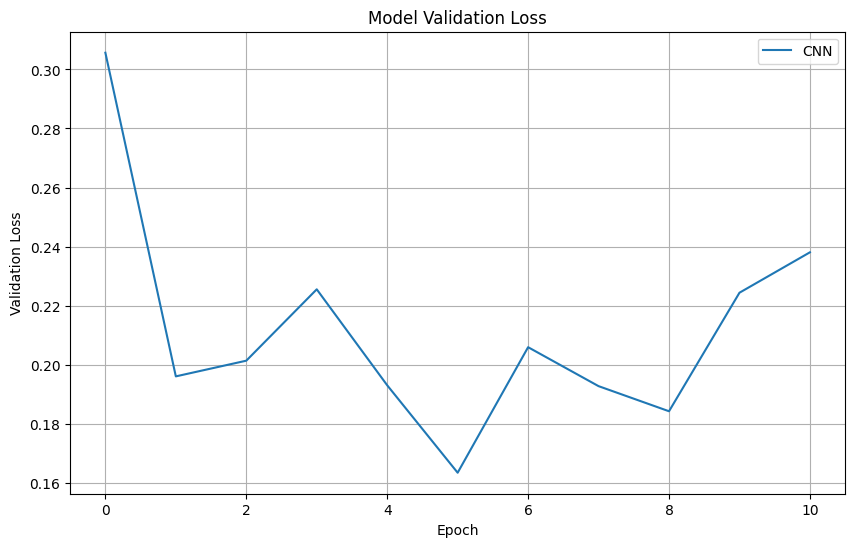

In [29]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_loss'], label=model)
plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

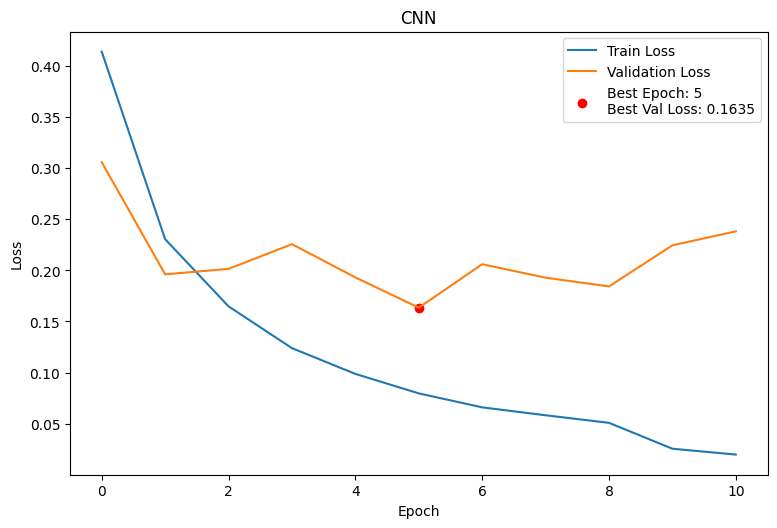

In [30]:
plt.figure(figsize=(15, 20))

# Sort models by least validation loss
sorted_models = sorted(history.items(), key=lambda x: min(x[1]['val_loss']))

# Plot each model based on sorted order of least val_loss
for i, (model_name, model_history) in enumerate(sorted_models, 1):
    plt.subplot(4, 2, i) 
    plt.plot(model_history['loss'], label='Train Loss')
    plt.plot(model_history['val_loss'], label='Validation Loss')

    # Find the best epoch based on least val_loss
    min_val_loss_epoch = model_history['val_loss'].index(min(model_history['val_loss']))
    min_val_loss = min(model_history['val_loss'])

    plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Best Epoch: {min_val_loss_epoch}\nBest Val Loss: {min_val_loss:.4f}')

    plt.title(model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

Accuracy values:
CNN: 0.9523


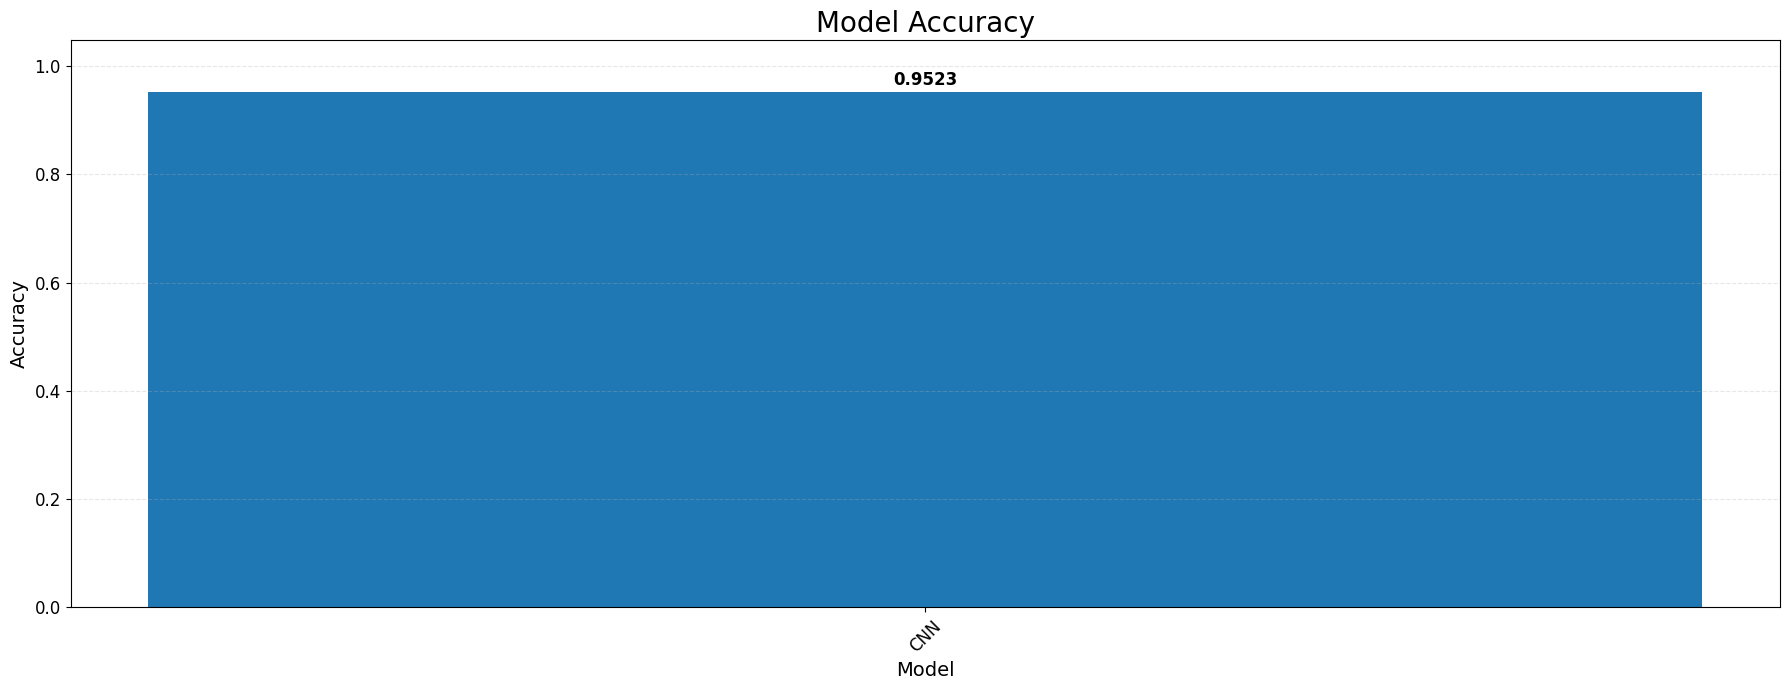

In [31]:
THE_ALL_RESULTS = {
    'CNN': cnn_result[1]
}

print("Accuracy values:")
for model, accuracy in THE_ALL_RESULTS.items():
    print(f"{model}: {accuracy:.4f}")

plt.figure(figsize=(18, 7))
bars = plt.bar(THE_ALL_RESULTS.keys(), THE_ALL_RESULTS.values(), 
               color=['#1f77b4'])

# Add value labels on top of each bar
for bar, (model, accuracy) in zip(bars, THE_ALL_RESULTS.items()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{accuracy:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Model Accuracy', fontsize=20)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limits to better show differences
plt.ylim(0, max(THE_ALL_RESULTS.values()) * 1.1)

plt.tight_layout()
plt.show()